In [21]:
from sigelmsync import sigelmsync
import matplotlib.pyplot as plt
import numpy as np
#
plt.style.use('helvet2')

In [3]:
shotnr=30554
ti=1.8
tf=2.8
preft=0.002
suft=0.008
divitem = 'jsat'
elm_exper = "guimas"
mintime = -preft*1e3
maxtime = suft*1e3

In [5]:
th, rh = sigelmsync(shotnr, "RDL", 'LFSR', ti=ti, tf=tf, preft=preft, suft=suft, elm_exper=elm_exper)

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:117: RuntimeWarning: Warning by DDcsgnl (8.1): no calibration of data
  warnings.warn(text.replace('\x00','').strip(), RuntimeWarning)
/afs/ipp/aug/ads-diags/common/python/lib/dd.py:117: RuntimeWarning: Warning by DDcsgrp (8.1): No PARAM_SET found
  warnings.warn(text.replace('\x00','').strip(), RuntimeWarning)


Reading from /home/guimas/diags/30554/uic.lp


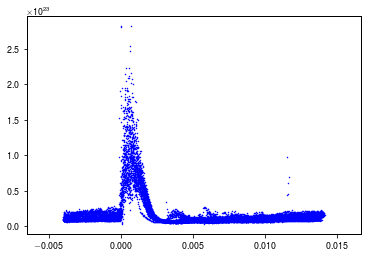

In [25]:
# %load /home/guimas/python/sigelmsync.py
#!/usr/bin/env python
import dd
import matplotlib.pylab as plt
import numpy as np
from readStark import *
import matplotlib.cm as cm

def sigelmsync(shotnr, diag, signal, ti=0.0, tf=10.0, preft=0.001, suft=0.004,
               elm_exper="AUGD", offset=False,
               file=None, concatenate=True):
    #################################
    ### Time Base ELM Sync:
    ### Gets a selected 1-D signal and syncs it to the ELMs in the desired time interval
    #################################
    ##Flag to check if data came from a signal group, set to False by default
    sgrp = False

    ###### Gets ELM data ############
    ELM = dd.shotfile("ELM", shotnr, experiment=elm_exper)
    elmd = ELM("t_endELM", tBegin=ti, tEnd=tf)
    t_endELM = elmd.data
    t_begELM = elmd.time
    ELM.close()
    ##################################
    
    ##Gets the custom file, ignores diag and signal, but they must be set for the time being
    if file is not None:
        print "Reading from " + str(file)
        try:
            a = np.loadtxt(str(file))
        except:
            print "No such file: " + file
            raise

        ###Check what data we have in the file
        if (a.shape[1] > 2): #It's a Signal Group
            sigtime = a[:,0]
            sigdata = a[:,1:a.shape[1]-1]
        elif ( a.shape[1] == 2): #It's a 1-D signal, two columns
            sigtime = a[:,0]
            sigdata = a[:,1]
        else: #No idea
            print "Yeah, the file you chose is not ok..."
            print "Take a look at " + file
            raise ValueError
    else: ###Not from a file
        #### Open with dd libraries ############
        DIAG = dd.shotfile(diag, shotnr)
        SIG = DIAG(signal, tBegin=ti, tEnd=tf)
        sigtime = SIG.time
        sigdata = SIG.data
        if (len(SIG.data.shape) >1):
            if (SIG.data.shape[1] > 2):
                sgrp = True
        DIAG.close()
        #################################

    # Remove Offset (bolometers, etc)
    if (offset):
        nptsoff = 20
        if (sgrp): #If it's a Signal Group
            sumoff = 0
            for chan in range(len(sigdata[1,:])):
                sumoff = np.sum(sigdata[2:2+nptsoff-1, chan])/float(nptsoff)
                sigdata[:, chan] = sigdata[:, chan] - sumoff
        else:
            sumoff = np.sum(sigdata[2:2+nptsoff-1])/float(nptsoff)
            sigdata = sigdata - sumoff

    #################### Syncs the timebase to the ELM timebase 
    synctime = []
    ###########################
    ###### Signal group
    ###########################
    if sgrp:
        sigdataT = sigdata.T
        chanlen = len(sigdata[0, :])        
        #syncsig = list(chanlen)
        syncsig = [[]]*chanlen
        for elm in range(t_begELM.size):
            t1,t2 =  t_begELM[elm]-preft, t_endELM[elm]+suft

            if (elm >=1 ) :
                tendprev = t_endELM[elm-1]                
                t1 = np.max([t1,tendprev])
            if  (elm<t_begELM.size-1):
                tstartnext =  t_begELM[elm+1]
                t2 = np.min([t2,tstartnext])

            elmind = np.where((sigtime >= t1) & (sigtime <=t2))
            synctime.append(sigtime[elmind]-t_begELM[elm])
            syncsig.append(sigdata[elmind])
        
            for chan in range(chanlen):
                syncsig[chan] = np.append(syncsig[chan], [sigdataT[chan,elmind][0]])

        return np.concatenate(synctime), syncsig
    ###########################
    ###### 1-D signal
    ###########################
    else:
        syncsig = []
        for elm in range(t_begELM.size):
            t1,t2 =  t_begELM[elm]-preft, t_endELM[elm]+suft

            if (elm >=1 ) :
                tendprev = t_endELM[elm-1]                
                t1 = np.max([t1,tendprev])
            if  (elm<t_begELM.size-1):
                tstartnext =  t_begELM[elm+1]
                t2 = np.min([t2,tstartnext])

            elmind = np.where((sigtime >= t1) & (sigtime <=t2))
            synctime.append(sigtime[elmind]-t_begELM[elm])
            syncsig.append(sigdata[elmind])
    #Concatenate all arrays so we have only a single array            
        if concatenate:
            return np.concatenate(synctime), np.concatenate(syncsig, axis=0)            
        else:
            return np.array(synctime), np.array(syncsig)

if __name__=="__main__":
    ###Example for a 1-D signal
    #t, s = sigelmsync(30554, "XVS", "S2L1A10", ti=1.7, tf=2.8, preft=0.004, suft=0.012)
    #plt.scatter(t, s, s=1.0, color="b", edgecolors="b")

    ###Example for a file call
    t, s = sigelmsync(30554, "XVS", "S2L1A10", ti=1.7, tf=2.8, preft=0.004, suft=0.012, file="/home/guimas/diags/30554/uic.lp")
    plt.scatter(t, s, s=1.0, color="b", edgecolors="b")

    ####Example for a Signal Group
    #t, s = sigelmsync(33583, "RIL", "RhoAnt8", ti=3.7, tf=4.8, preft=0.004, suft=0.006, offset=False)
    #t, s = sigelmsync(30554, "RDL", "LFSR", ti=1.7, tf=2.8, preft=0.004, suft=0.012, offset=False)
    #s = s[:4]
    #colors = cm.rainbow(np.linspace(0, 1, len(s)))    
    #for i in range(len(s)):
    #    plt.scatter(t, s[i], c=colors[i], edgecolors=colors[i], s=1.0)

    plt.show()


In [72]:
t, s = sigelmsync(30554, "RDL", "LFSR", ti=1.7, tf=2.8, preft=0.004, suft=0.012, elm_exper='guimas', concatenate=True)

In [73]:
plt.scatter(t,s[40])
plt.show()

ValueError: x and y must be the same size

In [78]:
from getsig import getsig

In [79]:
def rdlELMsync(shotnr=30554, ti=0.0, tf=10.0,
               preft=0.001, suft=0.004,
               exper="AUGD", elm_exper="AUGD", 
               siggrp='LFSR'):
    """Returns the ELM synced RDL data"""
    
    #Read RDL data and densities
    rdl = getsig(shotnr, 'RDL', siggrp, tBegin=ti, tEnd=tf, exper=exper)
    
    rdl = dd.shotfile('RDL', shotnr, experiment=exper)
    
    densities = rdl.get
    rdl.close()
    
    #Get the ELM data
    
    return rdl
    

In [112]:
lfsr = getsig(shotnr, 'RDL', 'LFSR', tBegin=1.0, tEnd=5.0, exper='AUGD')
rdl = dd.shotfile('RDL', shotnr, experiment='AUGD')
param = rdl.getParameter("Aux", "ne")
densities = np.array(param.data)
rdl.close()    

In [142]:
zval = np.ones_like(lfsr.data)
tval = np.ones_like(lfsr.data)
for i in range(len(densities)):
    zval[:,i] *= densities[i] 
    tval[:,i] *= lfsr.time

In [156]:
mindens = 0.2e19
maxdens = 6e19
indint = (zval>=mindens)&(zval<=maxdens)

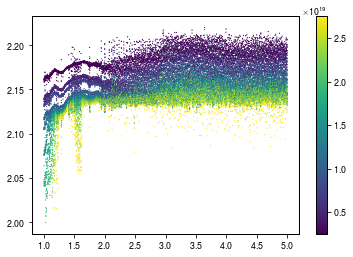

In [157]:
sc = plt.scatter(tval[indint], lfsr.data[indint], c=zval[indint],s=0.4)
plt.colorbar(sc)

plt.show()

In [139]:
zval.shape

(4001, 12)

In [80]:
rdl = rdlELMsync()

/afs/ipp/aug/ads-diags/common/python/lib/dd_20180216.py:117: RuntimeWarning: Warning by DDcsgrp (8.1): No PARAM_SET found
  warnings.warn(text.replace('\x00','').strip(), RuntimeWarning)


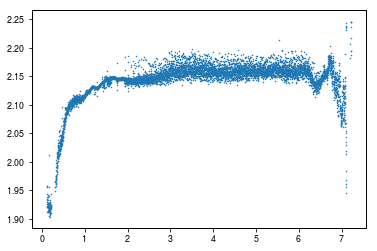

In [90]:
plt.scatter(rdl.time, rdl.data[:,3],s=1)
plt.show()

In [88]:
rdl.data[:,3]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [30]:
b = np.array([3,3,3,3,3])

In [77]:
t.shape

(568,)

In [1]:
import matplotlib.pyplot as plt
from getsig import getsig
plt.style.use('helvet2')

In [2]:
felm = getsig(30554, 'ELM', 'f_ELM')
freq_elm = getsig(30554, 'ELM', 'freq_ELM')

/afs/ipp/aug/ads-diags/common/python/lib/dd_20180216.py:117: RuntimeWarning: Warning by DDcsgnl (8.1): no calibration of data
  warnings.warn(text.replace('\x00','').strip(), RuntimeWarning)


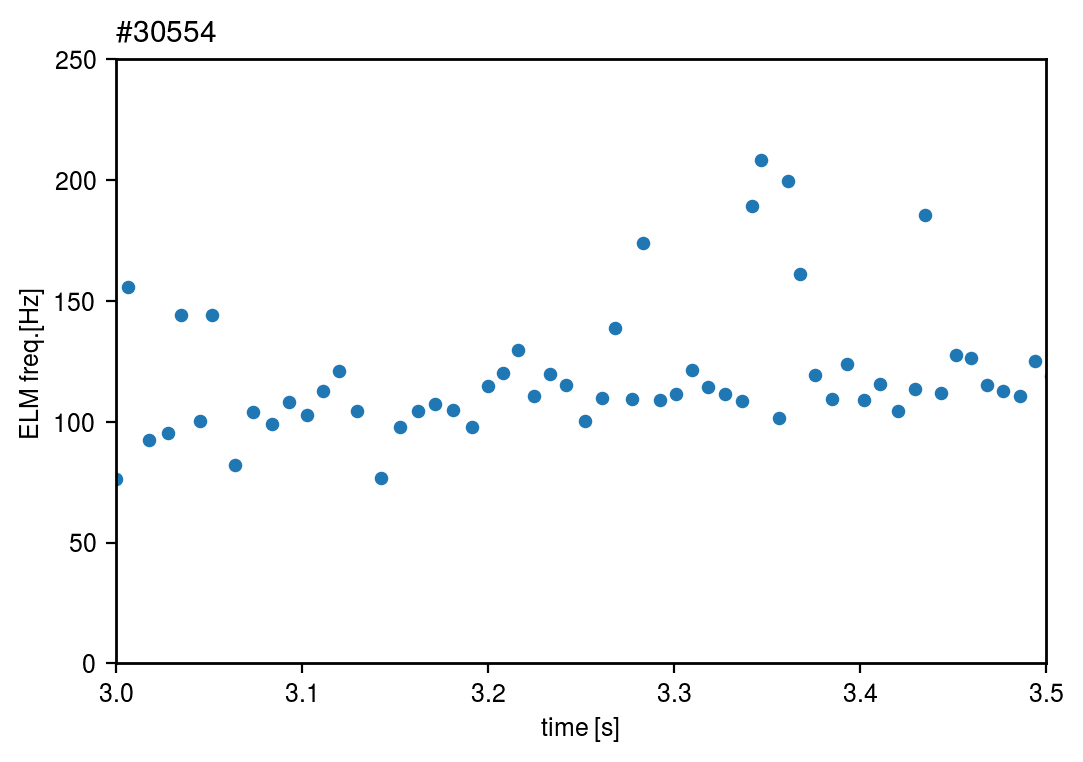

In [17]:
#plt.plot(felm.time, felm.data)
plt.figure(dpi=200)
plt.scatter(freq_elm.time, freq_elm.data, s=19)
plt.xlim(3.0,3.5)
plt.ylim(0, 250)
plt.xlabel('time [s]')
plt.ylabel('ELM freq.[Hz]')
plt.title(r'\#30554', loc='left')
plt.show()